In [2]:
import yfinance as yf

from datetime import datetime, timedelta

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


In [3]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)

In [4]:
# Simulate Buying and Selling Stock Using ARMA(p,q)
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1

#if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [5]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

Text(0, 0.5, 'Prices')

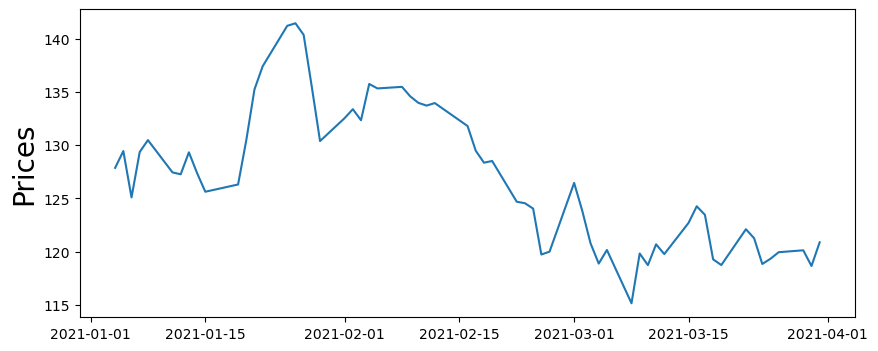

In [6]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

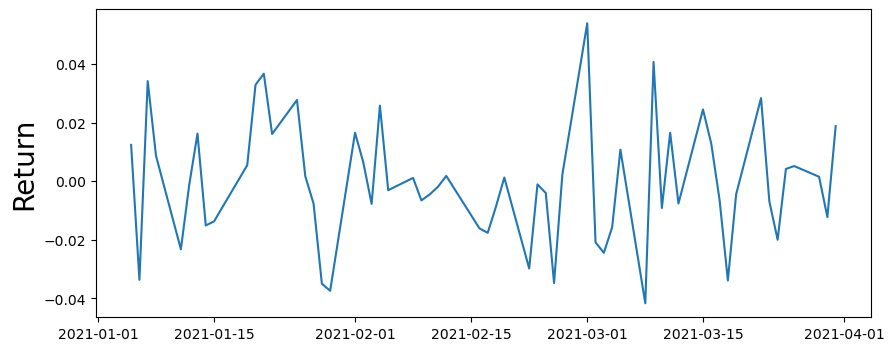

In [7]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

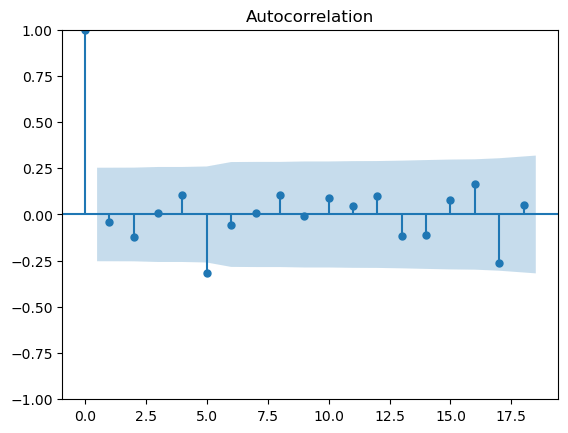

In [8]:
plot_acf(returns)
plt.show()

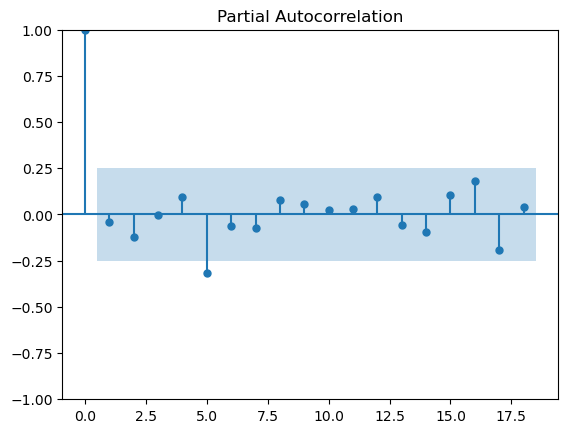

In [13]:
plot_pacf(returns, method='ywm')
plt.show()

100%|██████████| 46/46 [00:00<00:00, 1456.92it/s]


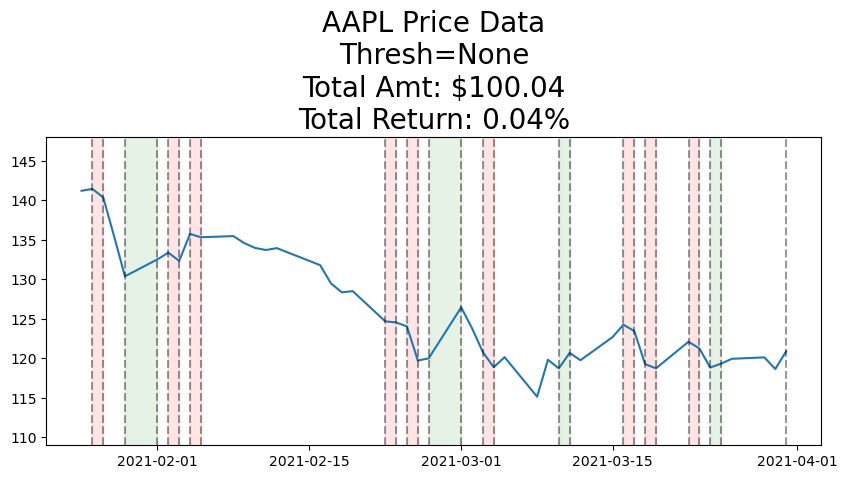

100.04083773472372

In [14]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

In [15]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

100%|██████████| 46/46 [00:00<00:00, 638.92it/s]


C:\Users\equipo\AppData\Local\Temp\ipykernel_10616\2783033276.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)


Text(0.5, 1.0, 'Avg: $95.14\nSD: $6.25')

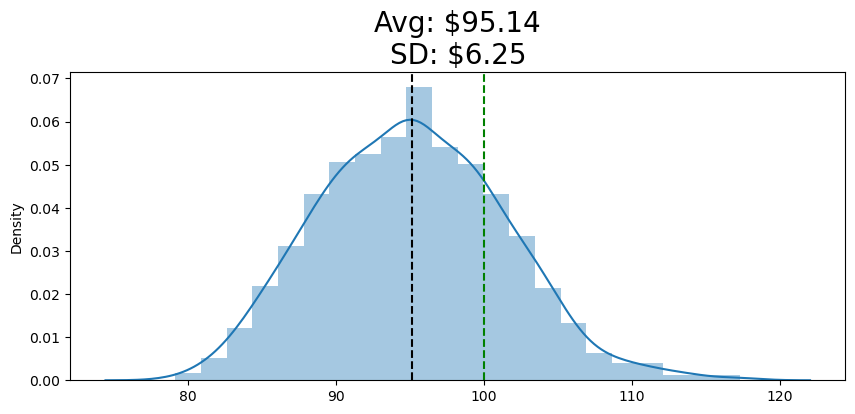

In [16]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

100%|██████████| 46/46 [00:00<00:00, 2874.87it/s]


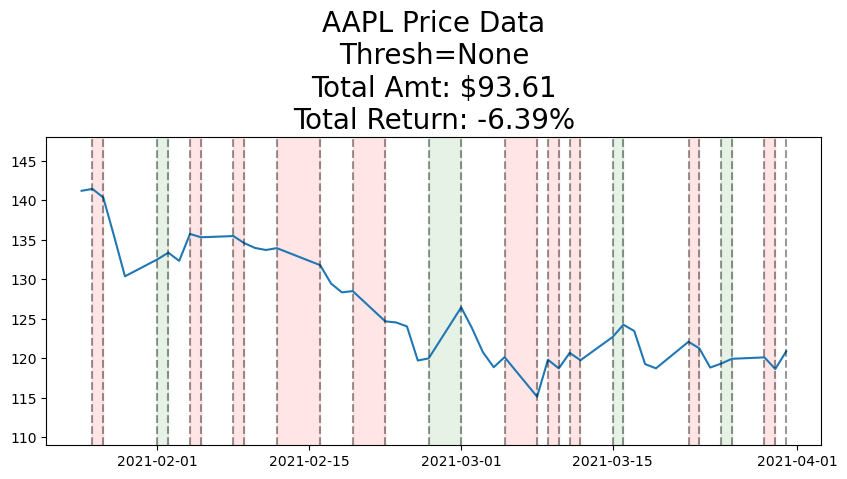

93.60996416525045

In [18]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

100%|██████████| 46/46 [00:00<00:00, 1916.94it/s]


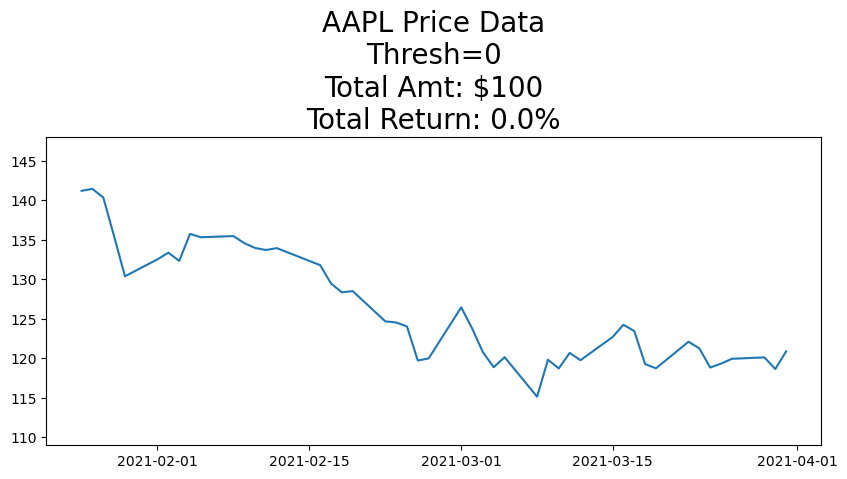

100%|██████████| 46/46 [00:00<00:00, 1915.95it/s]


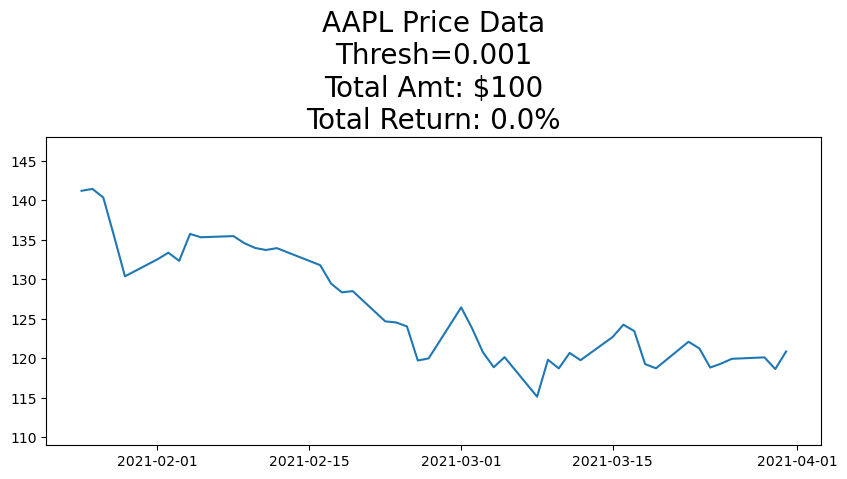

100%|██████████| 46/46 [00:00<00:00, 2533.56it/s]


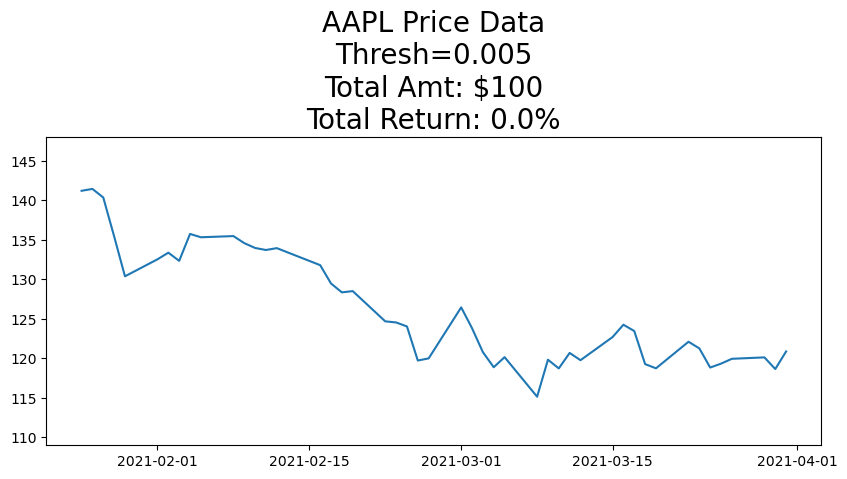

In [19]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

100%|██████████| 46/46 [00:00<00:00, 1916.75it/s]


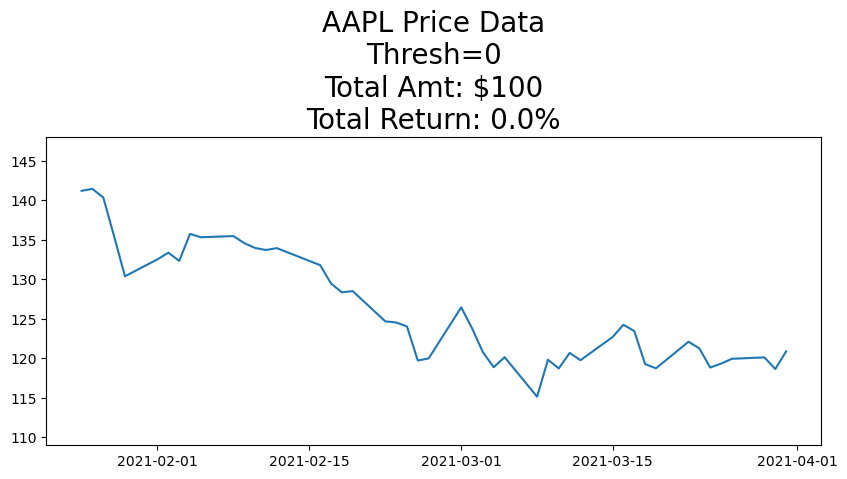

100%|██████████| 46/46 [00:00<00:00, 1912.83it/s]


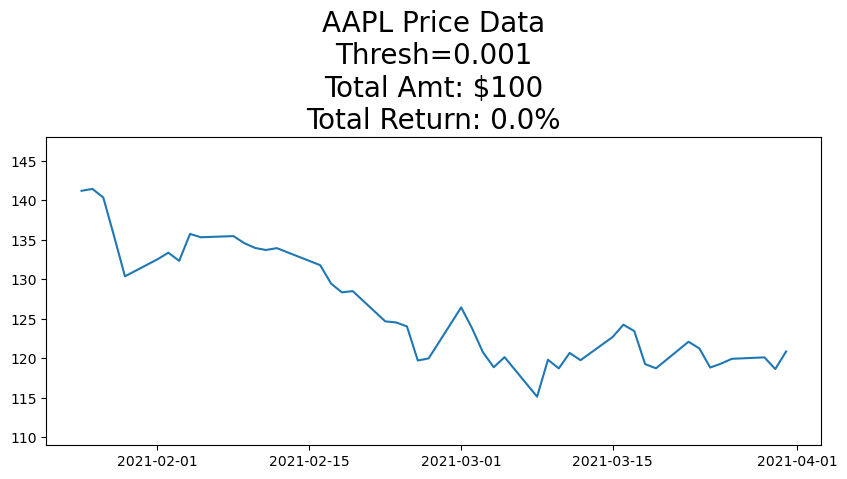

100%|██████████| 46/46 [00:00<00:00, 5749.90it/s]


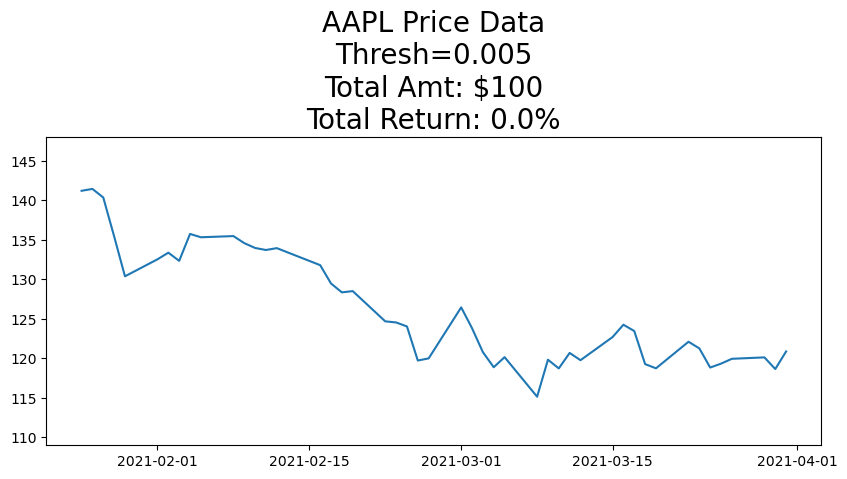

In [20]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

100%|██████████| 46/46 [00:00<00:00, 3045.30it/s]


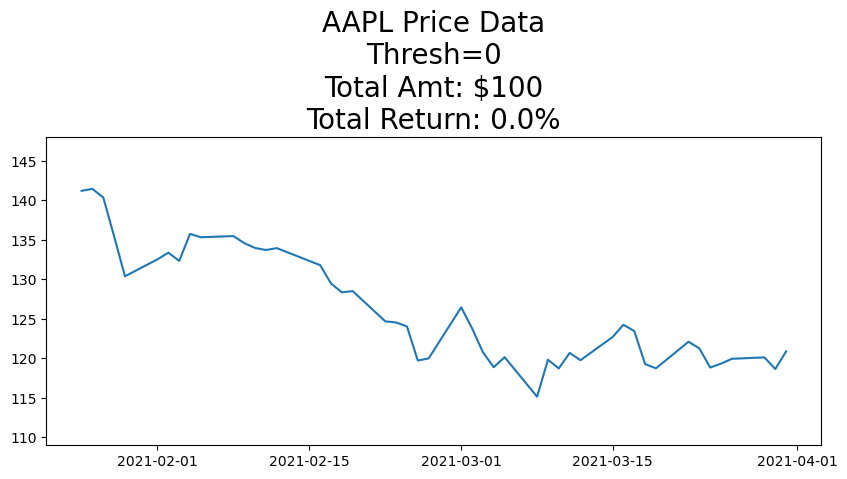

100%|██████████| 46/46 [00:00<00:00, 1437.42it/s]


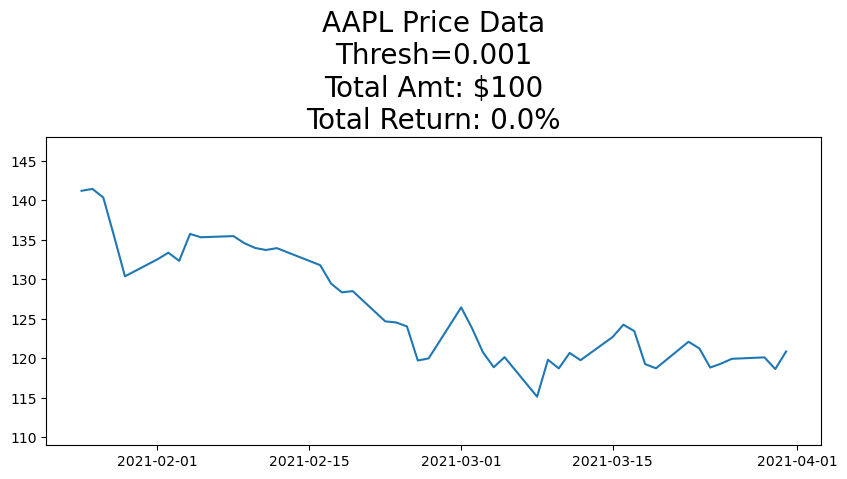

100%|██████████| 46/46 [00:00<00:00, 5750.25it/s]


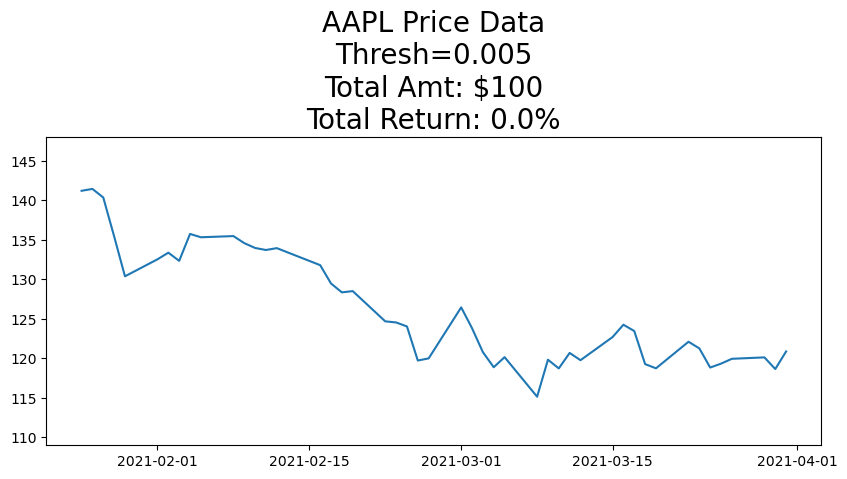

In [21]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)